In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the dataset
CONTEXT_LENGTH = 5
DELIMITER = "."
N_EMBEDDINGS = 12
N_HIDDEN = 512
BATCH_SIZE = 64
EPOCHS = 200_000
# n ois a short alias for BATCH_SIZE
n = BATCH_SIZE
# learning rate parameters
LR_START = 0.1
LR_END = 0.01
K = 1.3  # LR decay rate

In [4]:
# build the vocabulary
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi[DELIMITER] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for word in words:
        context = [0] * CONTEXT_LENGTH
        for char in word + DELIMITER:
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [6]:
# utility to compare manual gradient with torch's version
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:20s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff:e}"
    )

Initializating many of these parameters in non-standard ways because sometimes initializating with e.g. all zeros could mask an incorrect implementation of the backward pass.

In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, N_EMBEDDINGS), generator=g)

# first layer
W1 = (
    torch.randn((N_EMBEDDINGS * CONTEXT_LENGTH, N_HIDDEN), generator=g)
    * (5 / 3)
    / ((N_EMBEDDINGS * CONTEXT_LENGTH) ** 0.5)
)
b1 = torch.randn(N_HIDDEN, generator=g) * 0.1

# second layer
W2 = torch.randn((N_HIDDEN, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
batch_norm_gain = torch.randn((1, N_HIDDEN), generator=g) * 0.1 + 1.0
batch_norm_bias = torch.randn((1, N_HIDDEN), generator=g) * 0.1

parameters = [C, W1, b1, W2, b2, batch_norm_gain, batch_norm_bias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46431


In [8]:
# construct minibatch
ix = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)
X_batch, Y_batch = X_train[ix], Y_train[ix]

In [9]:
# forward pass
embeddings = C[X_batch]
embeddings_concat = embeddings.view(embeddings.shape[0], -1)
# linear layer 1
h_pre_batch_norm = embeddings_concat @ W1 + b1
# BatchNorm layer
batch_norm_mean_i = 1 / n * h_pre_batch_norm.sum(0, keepdim=True)
batch_norm_diff = h_pre_batch_norm - batch_norm_mean_i
batch_norm_diff_2 = batch_norm_diff**2
batch_norm_var = 1 / (n - 1) * (batch_norm_diff_2).sum(0, keepdim=True)
batch_norm_var_inv = (batch_norm_var + 1e-5) ** -0.5
batch_norm_raw = batch_norm_diff * batch_norm_var_inv
h_pre_act = batch_norm_gain * batch_norm_raw + batch_norm_bias
# Non-linearity
h = torch.tanh(h_pre_act)
# Linear layer 2
logits = h @ W2 + b2
# cross entropy
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Y_batch].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,
    norm_logits,
    logit_maxes,
    logits,
    h,
    h_pre_act,
    batch_norm_raw,
    batch_norm_var_inv,
    batch_norm_var,
    batch_norm_diff_2,
    batch_norm_diff,
    h_pre_batch_norm,
    batch_norm_mean_i,
    embeddings_concat,
    embeddings,
]:
    t.retain_grad()
loss.backward()
loss

tensor(4.0187, grad_fn=<NegBackward0>)

## Manual gradients

In [10]:
# dlogprobs
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Y_batch] = -1 / n
dprobs = 1 / probs * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum  # second branch
dnorm_logits = counts * dcounts
dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)
dlogits = (
    dnorm_logits.clone()
    + F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
)
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dh_pre_act = (1.0 - h**2) * dh
dbatch_norm_gain = (batch_norm_raw * dh_pre_act).sum(0, keepdim=True)
dbatch_norm_bias = dh_pre_act.sum(0)
dbatch_norm_raw = batch_norm_gain * dh_pre_act
dbatch_norm_var_inv = (batch_norm_diff * dbatch_norm_raw).sum(0, keepdim=True)
dbatch_norm_diff = batch_norm_var_inv * dbatch_norm_raw
dbatch_norm_var = (-0.5 * (batch_norm_var + 1e-5) ** (-3 / 2)) * dbatch_norm_var_inv
dbatch_norm_diff_2 = 1 / (n - 1) * dbatch_norm_var.sum(0, keepdim=True)
dbatch_norm_diff += 2 * batch_norm_diff * dbatch_norm_diff_2
dbatch_norm_mean_i = -1.0 * dbatch_norm_diff.sum(0, keepdim=True)
dh_pre_batch_norm = dbatch_norm_diff + 1 / n * dbatch_norm_mean_i
dembeddings_concat = dh_pre_batch_norm @ W1.T
dW1 = embeddings_concat.T @ dh_pre_batch_norm
db1 = dh_pre_batch_norm.sum(0)
dembeddings = dembeddings_concat.view(-1, CONTEXT_LENGTH, N_EMBEDDINGS)
### dC
dC = torch.zeros_like(C)
for k in range(X_batch.shape[0]):
    for j in range(X_batch.shape[1]):
        ix = X_batch[k, j]
        dC[ix] += dembeddings[k, j]
### dC end

In [11]:
cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
cmp("h_pre_act", dh_pre_act, h_pre_act)
cmp("batch_norm_gain", dbatch_norm_gain, batch_norm_gain)
cmp("batch_norm_bias", dbatch_norm_bias, batch_norm_bias)
cmp("batch_norm_raw", dbatch_norm_raw, batch_norm_raw)
cmp("batch_norm_var_inv", dbatch_norm_var_inv, batch_norm_var_inv)
cmp("batch_norm_var", dbatch_norm_var, batch_norm_var)
cmp("batch_norm_diff_2", dbatch_norm_diff_2, batch_norm_diff_2)
cmp("batch_norm_diff", dbatch_norm_diff, batch_norm_diff)
cmp("batch_norm_mean_i", dbatch_norm_mean_i, batch_norm_mean_i)
cmp("h_pre_batch_norm", dh_pre_batch_norm, h_pre_batch_norm)
cmp("embeddings_concat", dembeddings_concat, embeddings_concat)
cmp("W1", dW1, W1)
cmp("b1", db1, b1)
cmp("embeddings", dembeddings, embeddings)
cmp("C", dC, C)

logprobs             | exact: True  | approximate: True  | maxdiff: 0.000000e+00
probs                | exact: True  | approximate: True  | maxdiff: 0.000000e+00
counts_sum_inv       | exact: True  | approximate: True  | maxdiff: 0.000000e+00
counts_sum           | exact: True  | approximate: True  | maxdiff: 0.000000e+00
counts               | exact: True  | approximate: True  | maxdiff: 0.000000e+00
norm_logits          | exact: True  | approximate: True  | maxdiff: 0.000000e+00
logit_maxes          | exact: True  | approximate: True  | maxdiff: 0.000000e+00
logits               | exact: True  | approximate: True  | maxdiff: 0.000000e+00
h                    | exact: True  | approximate: True  | maxdiff: 0.000000e+00
W2                   | exact: True  | approximate: True  | maxdiff: 0.000000e+00
b2                   | exact: True  | approximate: True  | maxdiff: 0.000000e+00
h_pre_act            | exact: False | approximate: True  | maxdiff: 4.656613e-10
batch_norm_gain      | exact

In [12]:
# exercise 2
dlogits = F.softmax(logits, 1)
dlogits[range(n), Y_batch] -= 1.0
dlogits /= n

cmp("logits", dlogits, logits)

logits               | exact: False | approximate: True  | maxdiff: 4.656613e-09


In [13]:
# exercise 3
dh_pre_batch_norm = (
    batch_norm_gain
    * batch_norm_var_inv
    / n
    * (
        n * dh_pre_act
        - dh_pre_act.sum(0)
        - n / (n - 1) * batch_norm_raw * (dh_pre_act * batch_norm_raw).sum(0)
    )
)

cmp("hpre_batch_norm", dh_pre_batch_norm, h_pre_batch_norm)

hpre_batch_norm      | exact: False | approximate: True  | maxdiff: 6.984919e-10


## Putting it all together

In [14]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, N_EMBEDDINGS), generator=g)

# first layer
W1 = (
    torch.randn((N_EMBEDDINGS * CONTEXT_LENGTH, N_HIDDEN), generator=g)
    * (5 / 3)
    / ((N_EMBEDDINGS * CONTEXT_LENGTH) ** 0.5)
)
b1 = torch.randn(N_HIDDEN, generator=g) * 0.1

# second layer
W2 = torch.randn((N_HIDDEN, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
batch_norm_gain = torch.randn((1, N_HIDDEN), generator=g) * 0.1 + 1.0
batch_norm_bias = torch.randn((1, N_HIDDEN), generator=g) * 0.1

parameters = [C, W1, b1, W2, b2, batch_norm_gain, batch_norm_bias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46431


In [15]:
lossi = []

progress_bar = tqdm(
    range(EPOCHS), desc="Epoch", miniters=20, mininterval=0.5, maxinterval=1
)
with torch.no_grad():
    for i in progress_bar:
        ix = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)
        X_batch, Y_batch = X_train[ix], Y_train[ix]

        # forward pass
        embeddings = C[X_batch]
        embeddings_concat = embeddings.view(embeddings.shape[0], -1)

        # Linear layer
        h_pre_batch_norm = embeddings_concat @ W1 + b1

        # BatchNorm Layer
        batch_norm_mean = h_pre_batch_norm.mean(0, keepdim=True)
        batch_norm_var = h_pre_batch_norm.var(0, keepdim=True, unbiased=True)
        batch_norm_var_inv = (batch_norm_var + 1e-5) ** -0.5
        batch_norm_raw = (h_pre_batch_norm - batch_norm_mean) * batch_norm_var_inv
        h_pre_act = batch_norm_gain * batch_norm_raw + batch_norm_bias

        # Activation
        h = torch.tanh(h_pre_act)

        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_batch)

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward()

        # Manual backpropagation
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Y_batch] -= 1.0
        dlogits /= n
        # 2nd layers backpropagation
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dh_pre_act = (1.0 - h**2) * dh
        # batchnorm backprop
        dbatch_norm_gain = (batch_norm_raw * dh_pre_act).sum(0, keepdim=True)
        dbatch_norm_bias = dh_pre_act.sum(0, keepdim=True)
        dh_pre_batch_norm = (
            batch_norm_gain
            * batch_norm_var_inv
            / n
            * (
                n * dh_pre_act
                - dh_pre_act.sum(0)
                - n / (n - 1) * batch_norm_raw * (dh_pre_act * batch_norm_raw).sum(0)
            )
        )
        # 1st layer
        dembeddings_concat = dh_pre_batch_norm @ W1.T
        dW1 = embeddings_concat.T @ dh_pre_batch_norm
        db1 = dh_pre_batch_norm.sum(0)
        # embedding
        dembeddings = dembeddings_concat.view(embeddings.shape)
        dC = torch.zeros_like(C)
        for k in range(X_batch.shape[0]):
            for j in range(X_batch.shape[1]):
                ix = X_batch[k, j]
                dC[ix] += dembeddings[k, j]

        gradients = [dC, dW1, db1, dW2, db2, dbatch_norm_gain, dbatch_norm_bias]

        # update
        lr = LR_END + (LR_START - LR_END) * math.exp(-K * (i / EPOCHS))
        for p, gradient in zip(parameters, gradients):
            # if p.grad is not None:
            #     p.data += -lr * p.grad
            p.data += -lr * gradient

        lossi.append(loss.log10().item())

        progress_bar.set_postfix(loss=f"{loss:6f}", lr=f"{lr:.6f}", refresh=False)

Epoch:   0%|          | 0/200000 [00:00<?, ?it/s]

In [16]:
# useful for checking your gradients
# for p, g in zip(parameters, gradients):
#     cmp(str(tuple(p.shape)), g, p)

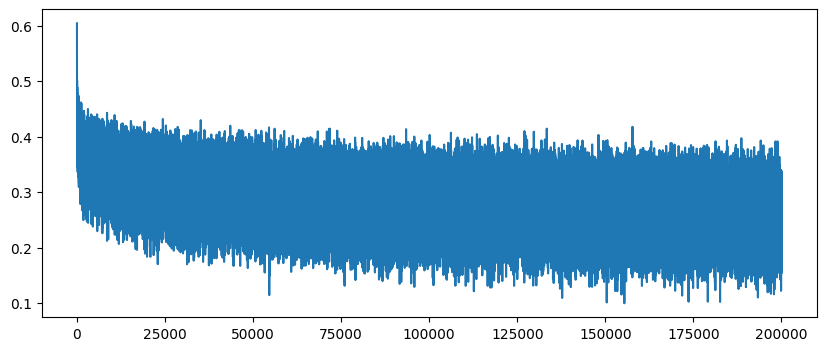

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(lossi)

In [18]:
with torch.no_grad():
    embeddings = C[X_train]
    embeddings_concat = embeddings.view(embeddings.shape[0], -1)
    h_pre_act = embeddings_concat @ W1 + b1
    batch_norm_mean = h_pre_act.mean(0, keepdim=True)
    batch_norm_var = h_pre_act.var(0, keepdim=True, unbiased=True)

In [19]:
@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]

    embeddings = C[x]
    embeddings_concat = embeddings.view(embeddings.shape[0], -1)
    h_pre_batch_norm = embeddings_concat @ W1 + b1
    h_pre_act = (
        batch_norm_gain
        * (h_pre_batch_norm - batch_norm_mean)
        * (batch_norm_var + 1e-5) ** -0.5
        + batch_norm_bias
    )
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.794847846031189
val 2.038940906524658


In [20]:
# sample
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * CONTEXT_LENGTH
    while True:
        embeddings = C[torch.tensor([context])]
        embeddings_concat = embeddings.view(embeddings.shape[0], -1)
        h_pre_batch_norm = embeddings_concat @ W1 + b1
        h_pre_act = (
            batch_norm_gain
            * (h_pre_batch_norm - batch_norm_mean)
            * (batch_norm_var + 1e-5) ** -0.5
            + batch_norm_bias
        )
        h = torch.tanh(h_pre_act)
        logits = h @ W2 + b2

        # sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

monachmnaz.
seelen.
haylie.
emmasisa.
ramon.
derron.
lilleyghon.
leigh.
esmae.
raylynn.
honesti.
shubhagihi.
jess.
jerren.
jernel.
alfous.
kavder.
yurue.
elsy.
majestyn.
